# ML Compliance & Robustness: Noise, k-Anonymity e Aggregation
**Professore:** Gemini AI

In questo laboratorio esploreremo tecniche per rendere i modelli più robusti e i dati più sicuri, bilanciando l'utilità statistica con la protezione delle informazioni.

--- 
## 1. Noise Addition (Aggiunta di Rumore)
### Teoria
L'aggiunta di rumore gaussiano ai dati di input è una forma di **regolarizzazione**. Aiuta il modello a non focalizzarsi su dettagli irrilevanti dei dati di training (overfitting), migliorando la sua capacità di generalizzare.

Matematicamente, per ogni feature $x$, generiamo un nuovo valore $x'$:
$$x' = x + \epsilon \quad \text{dove} \quad \epsilon \sim \mathcal{N}(0, \sigma^2)$$

In ambito privacy, questo concetto è alla base della **Differential Privacy**, dove il rumore viene aggiunto per mascherare il contributo del singolo individuo.

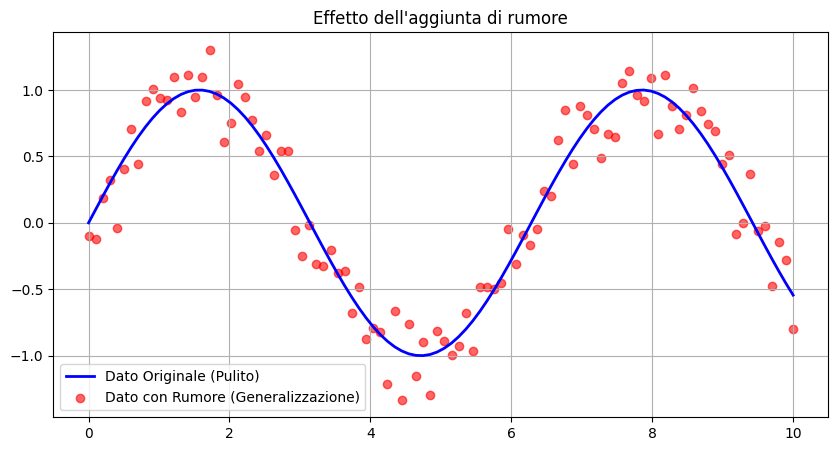

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Generazione dati originali (una semplice sinusoide)
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Aggiunta di rumore gaussiano
noise_std = 0.2
noise = np.random.normal(0, noise_std, size=x.shape)
y_noisy = y + noise

plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Dato Originale (Pulito)', color='blue', linewidth=2)
plt.scatter(x, y_noisy, label='Dato con Rumore (Generalizzazione)', color='red', alpha=0.6)
plt.title("Effetto dell'aggiunta di rumore")
plt.legend()
plt.grid(True)
plt.show()

--- 
## 2. k-Anonymity
### Teoria
Un dataset soddisfa la **k-Anonymity** se ogni individuo presente non può essere distinto da almeno $k-1$ altri individui che condividono gli stessi "quasi-identificatori" (es. Età, CAP, Genere).

Per ottenere la k-Anonymity si usano due tecniche:
1.  **Generalizzazione:** Trasformare valori specifici in range (es. Età 22 -> 20-30).
2.  **Soppressione:** Eliminare i record che non possono essere raggruppati.

In [5]:
import pandas as pd

# 1. Preparazione del Dataset "Sensitive"
data = {
    'Nome': ['Alice', 'Bob', 'Charlie', 'David', 'Eva', 'Frank', 'Grace'],
    'Età': [22, 28, 25, 41, 44, 42, 55],
    'CAP': ['10121', '10122', '10125', '20100', '20130', '20150', '30100'],
    'Diagnosi': ['Influenza', 'Raffreddore', 'Influenza', 'Diabete', 'Ipertensione', 'Diabete', 'Gastrite']
}
df = pd.DataFrame(data)

# 2. Parametri di Privacy
K = 3
QUASI_ID = ['Età', 'CAP']

def process_k_anonymity(df, k, qi_cols):
    df_temp = df.copy()
    
    # --- STEP 1: GENERALIZZAZIONE ---
    # Rendiamo i dati meno precisi per facilitare il raggruppamento
    # Trasformiamo l'età in fasce decennali (es. 22 -> 20-30)
    df_temp['Età'] = df_temp['Età'].apply(lambda x: f"{(x // 10) * 10}-{(x // 10) * 10 + 10}")
    
    # Trasformiamo il CAP oscurando le ultime cifre (es. 10121 -> 101**)
    df_temp['CAP'] = df_temp['CAP'].apply(lambda x: x[:3] + "**")
    
    # --- STEP 2: IDENTIFICAZIONE GRUPPI ---
    # Contiamo quante persone condividono gli stessi QI generalizzati
    group_counts = df_temp.groupby(qi_cols).size().reset_index(name='count_gruppo')
    
    # --- STEP 3: SOPPRESSIONE ---
    # Uniamo i conteggi al dataset e teniamo solo i gruppi >= K
    df_final = df_temp.merge(group_counts, on=qi_cols)
    
    # Filtriamo (soppressione dei record isolati) e rimuoviamo ID diretti (Nome)
    df_final = df_final[df_final['count_gruppo'] >= k]
    
    return df_final.drop(columns=['Nome', 'count_gruppo'])

# Esecuzione
df_anonymized = process_k_anonymity(df, K, QUASI_ID)

print("DATASET ORIGINALE:")
print(df)
print(f"\nDATASET ANONIMIZZATO (k={K}):")
print(df_anonymized)

DATASET ORIGINALE:
      Nome  Età    CAP      Diagnosi
0    Alice   22  10121     Influenza
1      Bob   28  10122   Raffreddore
2  Charlie   25  10125     Influenza
3    David   41  20100       Diabete
4      Eva   44  20130  Ipertensione
5    Frank   42  20150       Diabete
6    Grace   55  30100      Gastrite

DATASET ANONIMIZZATO (k=3):
     Età    CAP      Diagnosi
0  20-30  101**     Influenza
1  20-30  101**   Raffreddore
2  20-30  101**     Influenza
3  40-50  201**       Diabete
4  40-50  201**  Ipertensione
5  40-50  201**       Diabete


--- 
## 3. Data Aggregation
### Teoria
L'aggregazione è fondamentale per la **compliance GDPR**. Invece di analizzare il comportamento del singolo, analizziamo gruppi aggregati. Questo riduce drasticamente il rischio di data leakage pur mantenendo i trend statistici macroscopici.

Dati Aggregati per Reporting Compliance:


Categoria       Spesa                   
                   mean          sum count
0   Fashion  246.129734  8368.410966    34
1      Food  224.923417  8097.243024    36
2      Tech  258.159266  7744.777973    30

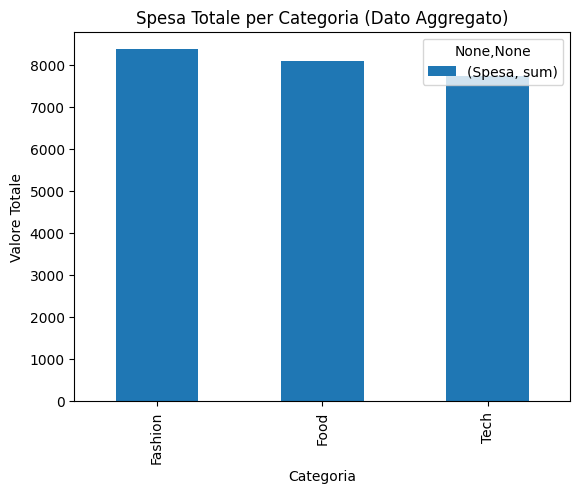

In [4]:
# Esempio di aggregazione per compliance
df_raw = pd.DataFrame({
    'UserID': range(100),
    'Spesa': np.random.uniform(10, 500, 100),
    'Categoria': np.random.choice(['Tech', 'Food', 'Fashion'], 100)
})

# Aggregazione: Calcoliamo la spesa media e totale per categoria
# Non sappiamo più quanto ha speso l'utente X, ma sappiamo come va il mercato
df_agg = df_raw.groupby('Categoria').agg({
    'Spesa': ['mean', 'sum', 'count']
}).reset_index()

print("Dati Aggregati per Reporting Compliance:")
display(df_agg)

# Visualizzazione
df_agg.plot(kind='bar', x='Categoria', y=('Spesa', 'sum'), title='Spesa Totale per Categoria (Dato Aggregato)')
plt.ylabel('Valore Totale')
plt.show()

### Conclusioni
- **Noise Addition:** Rende il modello meno sensibile alle fluttuazioni dei singoli dati.
- **k-Anonymity:** Protegge l'identità nascondendo l'individuo nella folla.
- **Aggregation:** Trasforma i dati personali in dati statistici, pronti per la compliance legale.